In [1]:
# Import necessary libraries
import math
import os
import json
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import heapq


# visualization
import folium
from folium.plugins import AntPath


In [2]:
df=pd.read_csv('worldcitiespop.csv')
Earth_R = 6371.0

C:\Users\Sayed Al Rafi\AppData\Local\Temp\ipykernel_2588\2666990264.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('worldcitiespop.csv')


In [3]:
df.head()

,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6.0,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6.0,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6.0,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6.0,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,6.0,NaN,42.466667,1.483333


In [6]:
df[df['City']=='high level']

,Country,City,AccentCity,Region,Population,Latitude,Longitude
348444,ca,high level,High Level,1,3621.0,58.516667,-117.133333
2909445,us,high level,High Level,AL,NaN,33.665556,-87.212778


In [4]:
df.isnull().sum()

Country             0
City                6
AccentCity          4
Region              8
Population    3125978
Latitude            0
Longitude           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     object 
 1   City        object 
 2   AccentCity  object 
 3   Region      object 
 4   Population  float64
 5   Latitude    float64
 6   Longitude   float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB


In [6]:
# Cell - 5 Clean and Normalize Columns
df = df.rename(columns={
    "Country": "country",
    "City": "city",
    "AccentCity": "accent_city",
    "Region": "region",
    "Population": "population",
    "Latitude": "lat",
    "Longitude": "lon"
})

# convert types
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
df["population"] = pd.to_numeric(df["population"], errors="coerce").fillna(0).astype(int)

# drop rows with no coordinates
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

print("Rows after cleaning:", len(df))
df.head()


Rows after cleaning: 3173958


,country,city,accent_city,region,population,lat,lon
0,ad,aixas,Aixàs,6.0,0,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6.0,0,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6.0,0,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6.0,0,42.466667,1.500000
4,ad,aixovall,Aixovall,6.0,0,42.466667,1.483333


In [7]:
# Cell 6- Duplicate cities
# keep one city per (country, city) pair → choose the one with largest population
df = df.sort_values("population", ascending=False).groupby(
    ["country", "city"], as_index=False
).first()

df = df.reset_index(drop=True)
print("Unique cities:", len(df))
df.head()

Unique cities: 2611442


,country,city,accent_city,region,population,lat,lon
0,ad,aixas,Aixàs,6.0,0,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6.0,0,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6.0,0,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6.0,0,42.466667,1.500000
4,ad,aixovall,Aixovall,6.0,0,42.466667,1.483333


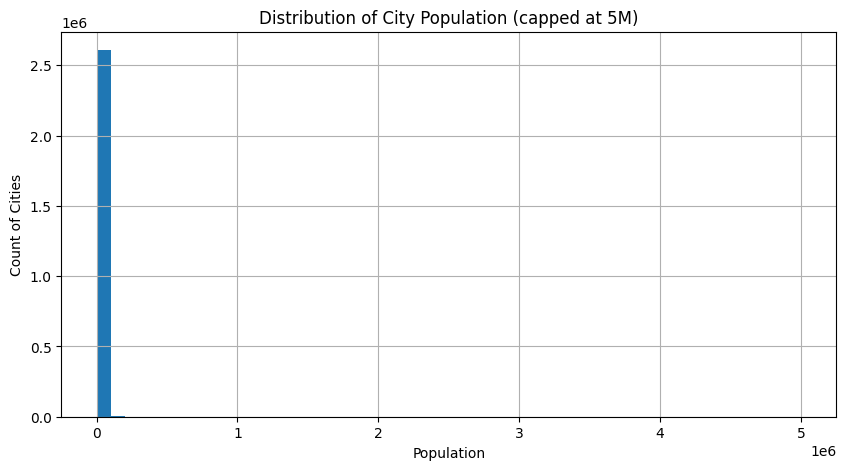

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df["population"].clip(upper=5000000).hist(bins=50)
plt.title("Distribution of City Population (capped at 5M)")
plt.xlabel("Population")
plt.ylabel("Count of Cities")
plt.show()


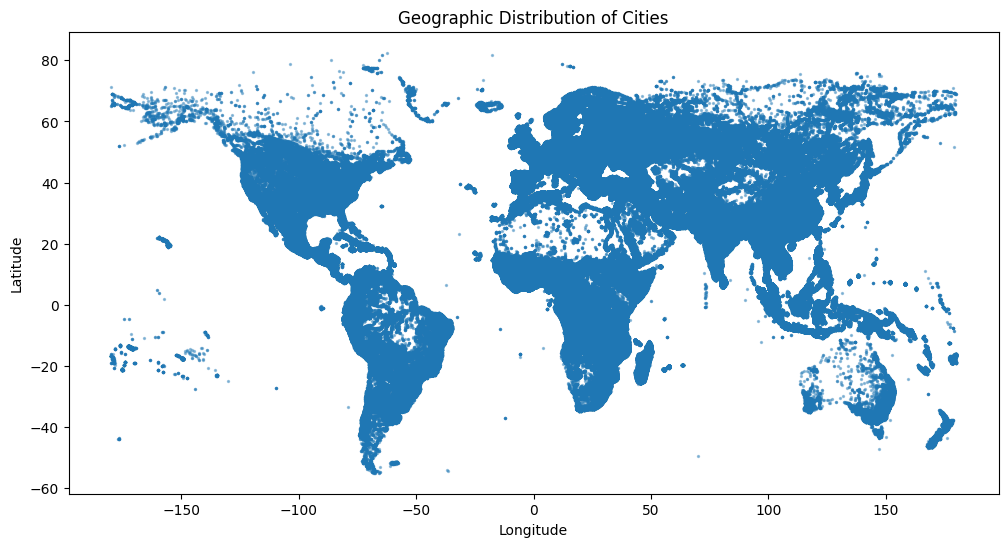

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(df["lon"], df["lat"], s=2, alpha=0.4)
plt.title("Geographic Distribution of Cities")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


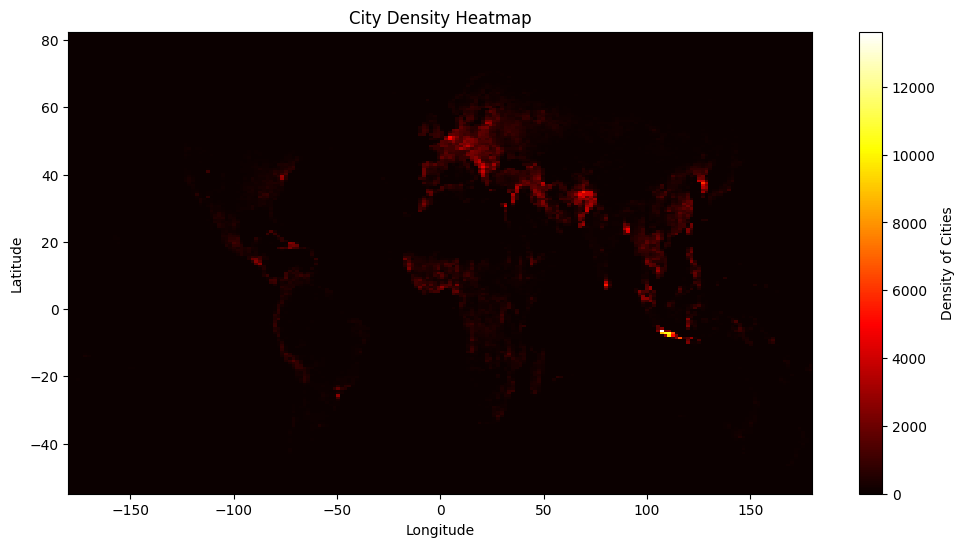

In [10]:
plt.figure(figsize=(12,6))
plt.hist2d(df["lon"], df["lat"], bins=200, cmap="hot")
plt.colorbar(label="Density of Cities")
plt.title("City Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [11]:
# Cell -7 Lon_mod + radians
df["lon_mod"] = (df["lon"] + 360) % 360
df["lat_rad"] = np.deg2rad(df["lat"])
df["lon_rad"] = np.deg2rad(df["lon"])

df.head()

,country,city,accent_city,region,population,lat,lon,lon_mod,lat_rad,lon_rad
0,ad,aixas,Aixàs,6.0,0,42.483333,1.466667,1.466667,0.741474,0.025598
1,ad,aixirivali,Aixirivali,6.0,0,42.466667,1.500000,1.500000,0.741183,0.026180
2,ad,aixirivall,Aixirivall,6.0,0,42.466667,1.500000,1.500000,0.741183,0.026180
3,ad,aixirvall,Aixirvall,6.0,0,42.466667,1.500000,1.500000,0.741183,0.026180
4,ad,aixovall,Aixovall,6.0,0,42.466667,1.483333,1.483333,0.741183,0.025889


In [12]:
# Cell 8 - Helper Function
def haversine_distance_km(lat1, lon1, lat2, lon2):
    R = Earth_R
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dl = math.radians(lon2 - lon1)
    a = (math.sin(dphi/2)**2 
         + math.cos(phi1) * math.cos(phi2) * math.sin(dl/2)**2)
    return 2 * R * math.asin(math.sqrt(a))

print("London → Paris km:", haversine_distance_km(51.5074, -0.1278, 48.8566, 2.3522))


London → Paris km: 343.55606034104164


In [13]:
# Cell 9-  Ball Tree for Nearest Neighbor Search
coords_rad = np.vstack([df["lat_rad"].values, df["lon_rad"].values]).T
tree = BallTree(coords_rad, metric="haversine")

K = 4  # self + 3 nearest
dist_rad, idx = tree.query(coords_rad, k=K)

# nearest 3 excluding self
nearest3 = []
for i in range(len(df)):
    neighbors = [j for j in idx[i] if j != i][:3]
    nearest3.append(neighbors)

print("Nearest neighbor list built for all cities.")

Nearest neighbor list built for all cities.


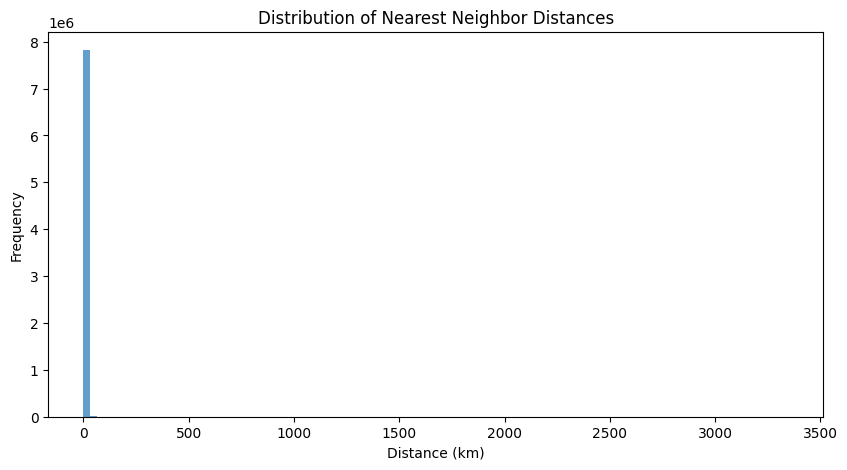

In [14]:
distances_km = (dist_rad[:,1:] * Earth_R).reshape(-1)

plt.figure(figsize=(10,5))
plt.hist(distances_km, bins=100, alpha=0.7)
plt.title("Distribution of Nearest Neighbor Distances")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

In [15]:
# Cell 10 - Build travel time graph
# Build Travel Time Graph
def travel_time_hours(src, dst, rank):
    base = {1:2, 2:4, 3:8}[rank]
    extra = 0
    if df.loc[src, "country"] != df.loc[dst, "country"]:
        extra += 2
    if df.loc[dst, "population"] > 200000:
        extra += 2
    return base + extra

n = len(df)
edges = {i: [] for i in range(n)}

for i in range(n):
    for rank, j in enumerate(nearest3[i], start=1):
        t = travel_time_hours(i, j, rank)
        edges[i].append((j, t))

print("Directed time graph built.")


Directed time graph built.


In [16]:
# Cell 11 Diijkstra's Algorithm
def shortest_with_path(start_city, df, edges, max_wraps=10):
    # find start index
    matches = df.index[df["city"].str.contains(start_city, case=False, na=False)].tolist()
    if not matches:
        raise ValueError("City not found:", start_city)
    start = matches[0]
    
    start_state = (start, 0)
    target_state = (start, 1)
    
    pq = [(0.0, start_state)]
    dist = {start_state: 0.0}
    prev = {}

    while pq:
        cost, (u, k) = heapq.heappop(pq)
        
        if (u, k) == target_state:
            # reconstruct
            path = []
            node = target_state
            while node in prev:
                path.append(node)
                node = prev[node]
            path.append(start_state)
            path.reverse()
            return cost, path
        
        lon_u = df.loc[u, "lon_mod"]
        for v, t in edges[u]:
            lon_v = df.loc[v, "lon_mod"]
            k2 = k if lon_v > lon_u else k + 1
            if k2 > max_wraps:
                continue
            state2 = (v, k2)
            new_cost = cost + t
            if new_cost < dist.get(state2, float("inf")):
                dist[state2] = new_cost
                prev[state2] = (u, k)
                heapq.heappush(pq, (new_cost, state2))
    
    return None, None


In [17]:
# Cell 12 Run Solver for a Given City
start_city = "London"

hours, path = shortest_with_path(start_city, df, edges, max_wraps=10)

if hours is None:
    print("No route found.")
else:
    print(f"Total hours: {hours:.1f}")
    print(f"Days: {hours/24:.2f}")
    print("Within 80 days?", hours <= 80*24)


Total hours: 6.0
Days: 0.25
Within 80 days? True


In [18]:
#  Cell 13 Reconstruct Route
if path:
    rows = []
    for step, (idx, w) in enumerate(path):
        rows.append({
            "step": step,
            "index": int(idx),              # <-- THIS IS WHERE INDEX IS ADDED
            "city": df.loc[idx, "city"],
            "country": df.loc[idx, "country"],
            "lat": df.loc[idx, "lat"],
            "lon": df.loc[idx, "lon"],
            "lon_mod": df.loc[idx, "lon_mod"],
            "wrap": w
        })
    route_df = pd.DataFrame(rows)
    route_df.head()
else:
    print("No path to show.")


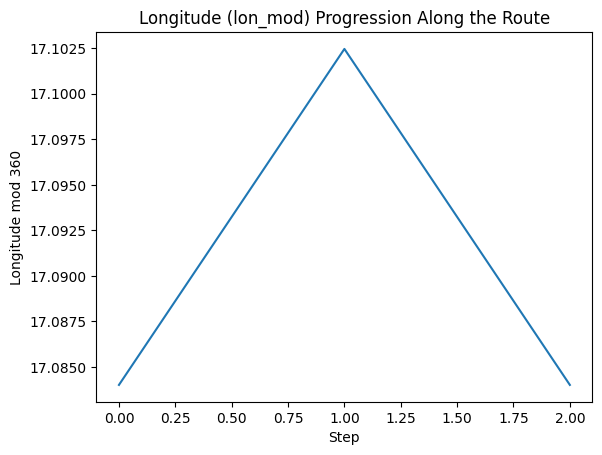

In [19]:
plt.plot(route_df["step"], route_df["lon_mod"])
plt.title("Longitude (lon_mod) Progression Along the Route")
plt.xlabel("Step")
plt.ylabel("Longitude mod 360")
plt.show()

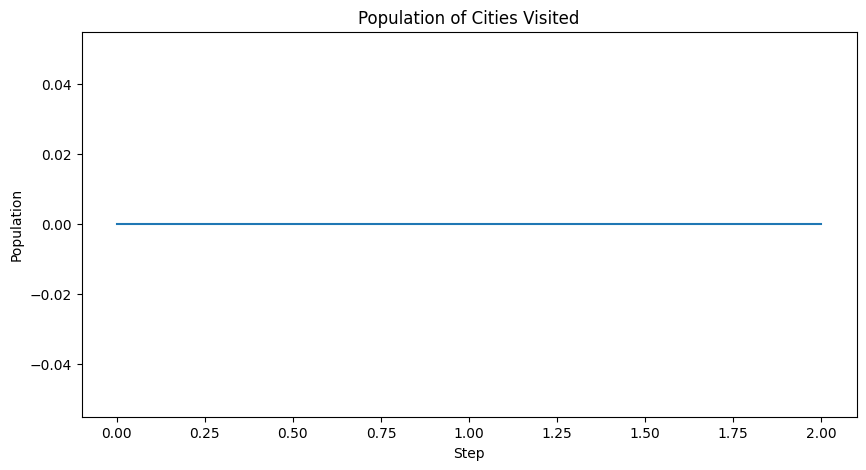

In [20]:
plt.figure(figsize=(10,5))
plt.plot(route_df["step"], df.loc[route_df["index"], "population"])
plt.title("Population of Cities Visited")
plt.xlabel("Step")
plt.ylabel("Population")
plt.show()


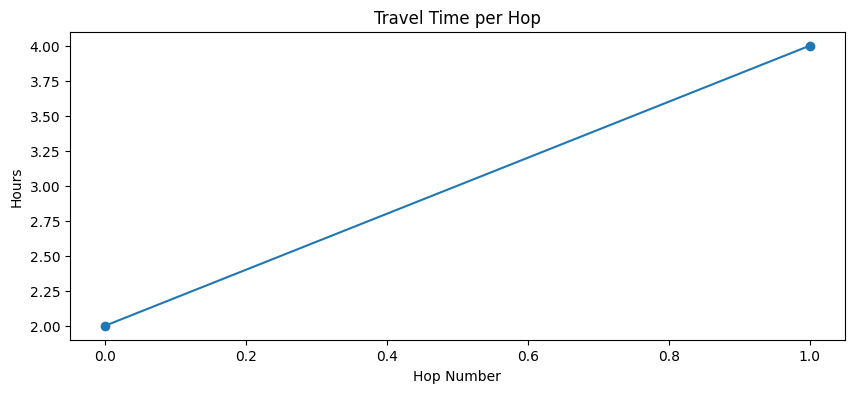

In [21]:
travel_times = []
for i in range(len(path)-1):
    u = path[i][0]
    v = path[i+1][0]
    # find travel time from edges[u]
    t = [t for (x,t) in edges[u] if x == v][0]
    travel_times.append(t)

plt.figure(figsize=(10,4))
plt.plot(travel_times, marker='o')
plt.title("Travel Time per Hop")
plt.xlabel("Hop Number")
plt.ylabel("Hours")
plt.show()


In [22]:
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [23]:
# Cell 14 Save route and summary
if path:
    route_df.to_csv(f"{RESULTS_DIR}/route_states.csv", index=False)
    summary = {
        "start_city": start_city,
        "hours": float(hours),
        "days": float(hours)/24,
        "within_80_days": hours <= 1920
    }
    with open(f"{RESULTS_DIR}/summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("Saved route and summary to results/")


Saved route and summary to results/


In [24]:
# Cell 15 - Folium Map
if path:
    m = folium.Map(location=[20, 0], zoom_start=2)
    
    coords = []
    for (idx, wrap) in path:
        lat = df.loc[idx, "lat"]
        lon = df.loc[idx, "lon"]
        coords.append((lat, lon))
        folium.CircleMarker(
            location=(lat, lon),
            radius=4,
            popup=f"{df.loc[idx,'city']} (wrap={wrap})"
        ).add_to(m)
    
    AntPath(coords).add_to(m)
    
    m.save(f"{RESULTS_DIR}/route_map.html")
    print("Map saved:", f"{RESULTS_DIR}/route_map.html")
else:
    print("No path to plot.")


Map saved: results/route_map.html


In [25]:
import streamlit as st